## Trabalho 1 - Avaliação e Desempenho

---

**Alunos**:

Abraham Banafo - 117074396

Claudio Netto - 113166858

Gabriel Christo - 117217732

Yago Alves - 115212477

Yuri Medeiros - 117061898

---

In [ ]:
import random
import math
from math import isclose
from collections import deque
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import scipy

import numpy as np
from scipy.stats import expon

In [ ]:
# Constantes

ARRIVAL = 0
END_OF_SERVICE = 1
MU = 1.0
IDLE = 0
BUSY = 1
FIFO = 0
LIFO = 1

N_RODADAS = 3200
MIN_CLIENTES = 100

T_PERCENTILE = 1.960 # alpha = 0.05

In [ ]:
def generate_exp(lambda_param):
  u0 = random.random() # Gera a variavel aleatoria uniforme no intervalo [0.0, 1.0)
  x0 = - math.log(u0) / lambda_param # Pega amostra da exponencial
  return x0

In [ ]:
class Event:
  def __init__(self, event_type, ocurrence_time, client_id):

    self.event_type = event_type # Chegada ou fim de serviço

    self.t = ocurrence_time # Instante que o evento ocorre

    self.client_id = client_id # ID do cliente ao qual o evento esta relacionado

  # Define como a classe vai ser impressa
  def __repr__(self) -> str:
    if self.event_type == ARRIVAL:
      type_str = "ARRIVAL"
    else:
      type_str = "END_OF_SERVICE"
    return f"event_type: {type_str}\nt: {self.t}\nclient_id: {self.client_id}"

class EventsList:
  def __init__(self):
    self.events = []
  def add(self, event):
    heapq.heappush(self.events, (event.t, event))
  def pop(self):
    # Pega o evento que ocorre mais cedo, já que a lista esta ordenada pelos tempos
    t, event = heapq.heappop(self.events)
    return event
  def clear(self):
    self.events.clear()

def get_event_time(event):
  return event.t

In [ ]:
class Client:
  def __init__(self, arrival_event):
    self.id = arrival_event.client_id
    self.arrival_time = arrival_event.t
    # tempo de espera até ser servido, deve ser alterado quando for atendido
    self.waiting_time = 0.0
  # Define como a classe vai ser impressa
  def __repr__(self) -> str:
    return f"id: {self.id}\narrival_time: {self.arrival_time}\nwaiting_time: {self.waiting_time}"

def create_client(event):
  # Cria uma instancia da classe Cliente
  new_client = Client(event)
  # Retorna referencia para o cliente criado
  return new_client

class ClientsQueue:
  def __init__(self):
    self.clients = deque([])
  def add(self, client):
    self.clients.append(client)
  def pop(self):
      return self.clients.popleft()
  def clear(self):
    self.clients.clear()


def serve_client(client, t, service_dist, events_list):
  # Registra o tempo de espera do serviço
  client.waiting_time = t - client.arrival_time
  # Cria evento do fim do serviço
  end_of_service_event = generate_end_of_service(t, service_dist, client.id)
  # Adiciona evento do fim do servico a lista de eventos
  events_list.add(end_of_service_event)

In [ ]:
def generate_arrival(t, arrival_dist, client_id):
  arrival = Event(ARRIVAL, t + arrival_dist(), client_id)
  return arrival

def generate_end_of_service(t, service_dist, client_id):
  end_of_service = Event(END_OF_SERVICE, t + service_dist(), client_id)
  return end_of_service

In [ ]:
class Estimator:
  def __init__(self):
    self.samples_list = [] # amostras
    self.samples_sum = 0.0 # Soma das amostras
    self.squares_sum = 0.0 # Soma dos quadrados das amostras
    self.n = 0 # Numero de amostras
  def add_sample(self, sample):
    self.samples_list.append(sample)
    self.samples_sum += sample
    self.squares_sum += (sample**2)
    self.n += 1
  def get_samples_list(self):
    return self.samples_list
  def mean(self):
    return self.samples_sum / self.n
  def variance(self):
    term1 = self.squares_sum / (self.n - 1)
    term2 = (self.samples_sum**2) / (self.n * (self.n - 1))
    return term1 - term2
  def tstudent_ci(self):
    term = T_PERCENTILE * (math.sqrt(self.variance())/math.sqrt(N_RODADAS))
    return self.mean() - term, self.mean() + term
  def clear(self):
    self.samples_sum = 0.0
    self.samples_list = []
    self.squares_sum = 0.0
    self.n = 0

class NqueueAreaEstimator:
  def __init__(self):
    # Soma das areas
    self.nqueue_area_sum = 0.0
    # Soma dos intervalos de tempo
    self.dt_sum = 0.0
  def add_sample(self, nqueue, dt):
    self.nqueue_area_sum += nqueue * dt
    self.dt_sum += dt
  def mean(self):
    return self.nqueue_area_sum / self.dt_sum
  def clear(self):
    self.nqueue_area_sum = 0.0
    self.dt_sum = 0.0

class NqueuePmfEstimator:
  def __init__(self):
    # Soma dos quadrados dos Nqis coletados vezes o intervalo de tempo
    self.nqueue_squares_sum = 0.0
    # Soma dos Nqis coletados vezes o intervalo de tempo
    self.nqueue_sum = 0.0
    # Soma dos intervalos de tempo
    self.dt_sum = 0.0
  def add_sample(self, nqueue, dt):
    self.nqueue_squares_sum += (nqueue**2) * dt
    self.nqueue_sum += nqueue * dt
    self.dt_sum += dt
  def variance(self):
    second_moment = self.nqueue_squares_sum / self.dt_sum
    first_moment = self.nqueue_sum / self.dt_sum
    return second_moment - (first_moment**2)
  def clear(self):
    self.nqueue_squares_sum = 0.0
    self.nqueue_sum = 0.0
    self.dt_sum = 0.0

In [ ]:
tempos_espera = 0

def print_CDF(num_clientes,tempos_espera):

  tempos_espera = np.sort(tempos_espera)

  cdf = np.arange(1, len(tempos_espera) + 1) / len(tempos_espera)

  # Plotar a CDF
  plt.plot(tempos_espera, cdf, marker='o')
  plt.xlabel('Tempo Médio de Espera')
  plt.ylabel('CDF')
  plt.title('CDF a partir dos Tempos Médios de Espera')
  plt.grid(True)

  # Mostrar o gráfico
  plt.show()


  num_clientes = np.sort(num_clientes)
  cdf_2 = np.arange(1, len(num_clientes) + 1) / len(num_clientes)

  # Plotar a CDF
  plt.plot(num_clientes, cdf_2, marker='o')
  plt.xlabel('Quantidade média de clientes ao longo das rodadas')
  plt.ylabel('CDF')
  plt.title('CDF a partir da quantidade média de clientes')
  plt.grid(True)

  # Mostrar o gráfico
  plt.show()


In [ ]:
def simulate(
    rounds,
    round_size,
    arrival_dist,
    service_dist,
    print_values=False,
    print_graph=False,
    graph_values=False,
):
    discipline = "FCFS"
    t = 0.0  # tempo inicial
    nqueue = 0  # numero de pessoas na fila de espera
    client_in_server = None  # Cliente no servidor

    client_id = 0  # ID inicial dos clientes

    first_arrival = generate_arrival(
        t, arrival_dist, client_id
    )  # Cria o evento inicial

    client_id += 1  # Incrementa o identificador de clientes
    # Cria a lista de eventos, com o evento inicial
    events_list = EventsList()
    events_list.add(first_arrival)

    clients_queue = ClientsQueue()  # Cria a fila de espera de clientes, vazia
    # Estimadores de tempo de espera e tamanho da fila
    time_est = Estimator()
    nqueue_est = Estimator()
    # Estimadores da variancia pela t-student
    time_var_est = Estimator()
    nqueue_var_est = Estimator()

    empty_queue_estimator = Estimator()

    roundW = []  # lista com os tempos de espera nas filas de cada rodada

    W = []  # lista com os valores do estimador de E[W] ao longo do tempo
    Nq = []  # lista com numeros de individuos na fila em cada rodada

    empty_queue_ocurrences = 0

    # Loop das Rodadas
    for i in range(rounds):
        # Numero de clientes servidos na rodada
        served_clients = 0
        # Inicia os estimadores de tempo de espera e tamanho da fila da rodada
        round_time_est = Estimator()
        round_nqueue_est = NqueueAreaEstimator()
        round_nqueue_pmf_est = NqueuePmfEstimator()

        nqueue = 0 # zerando tamanho da fila

        counter = 0
        while served_clients < round_size: # counter ?

            # Seleciona o próximo evento e tira da lista
            event = events_list.pop()
            # Salva o valor de Nq durante o intervalo de tempo ate o evento
            round_nqueue_est.add_sample(nqueue, event.t - t)
            round_nqueue_pmf_est.add_sample(nqueue, event.t - t)
            # Avança o tempo para o instante do evento
            t = event.t

            # Se o evento é uma CHEGADA
            if event.event_type == ARRIVAL:
                # Cria um cliente
                new_client = create_client(event)

                # Se o servidor esta LIVRE
                if not client_in_server:
                    # Coloca o cliente no servidor
                    client_in_server = new_client
                    # Registra tempo de espera e adiciona evento do fim do serviço na lista
                    serve_client(new_client, t, service_dist, events_list)

                # Se o servidor esta OCUPADO
                else:
                    # Adiciona o cliente na fila de espera
                    clients_queue.add(new_client)
                    # Incrementa numero de clientes na fila de espera
                    nqueue += 1

                # Incrementa id de cliente
                client_id += 1
                # Cria nova chegada
                new_arrival = generate_arrival(t, arrival_dist, client_id)
                # Adiciona nova chegada na lista de eventos
                events_list.add(new_arrival)



            # Se o evento é o FIM DE SERVIÇO
            else:

                # Salva o tempo de espera do cliente que acabou o serviço
                round_time_est.add_sample(client_in_server.waiting_time)
                # Incrementa numero de clientes que ja foram servidos na rodada
                served_clients += 1

                # Se nao ha NINGUEM na fila de espera
                if nqueue == 0:
                    # Muda status do servidor para vazio
                    client_in_server = None

                # Se ha ALGUEM na fila de espera
                else:
                    # Pega o proximo cliente
                    client = clients_queue.pop()
                    # Coloca o cliente no servidor
                    client_in_server = client
                    # Registra tempo de espera e adiciona evento do fim do serviço na lista
                    serve_client(client, t, service_dist, events_list)
                    # Decrementa numero de clientes na fila de espera
                    nqueue -= 1
                    # se a fila eh zerada, salvamos a ocorrencia para fracao de # de vezes que sistema atinge estado zero
                    if nqueue == 0:
                        empty_queue_ocurrences += 1

            counter += 1

        # salvando numero de vezes que sistema atingiu estado zero na rodada atual
        empty_queue_estimator.add_sample(empty_queue_ocurrences)
        empty_queue_ocurrences = 0

        # zerando tempo de simulação e lista de eventos/clientes para próxima rodada
        client_in_server = None
        client_id = 0
        t = 0
        clients_queue.clear()
        events_list.clear()
        events_list.add(generate_arrival(t, arrival_dist, client_id))
        client_id += 1

        # Calcula a estatisticas de W e Nq da rodada (amostras da rodada)
        round_time_mean = round_time_est.mean()
        round_time_var = round_time_est.variance()
        round_nqueue_mean = round_nqueue_est.mean()
        round_nqueue_var = round_nqueue_pmf_est.variance()

        # Salva as amostras da rodada nos estimadores gerais
        time_est.add_sample(round_time_mean)
        time_var_est.add_sample(round_time_var)
        nqueue_est.add_sample(round_nqueue_mean)
        nqueue_var_est.add_sample(round_nqueue_var)

        # zerando estimadores
        round_time_est.clear()
        round_nqueue_est.clear()
        round_nqueue_pmf_est.clear()

        # Salva amostras para o grafico, se desejado
        if graph_values:
            W.append(time_est.mean())
            Nq.append(nqueue_est.mean())

    if graph_values:
        print_CDF(Nq, W)

    # Obtem os intervalos de confiança e seus centros
    # t-student para media do tempo
    w_mean_lower, w_mean_upper = time_est.tstudent_ci()
    w_mean_center = time_est.mean()
    # t-student para variancia do tempo
    w_var_lower2, w_var_upper2 = time_var_est.tstudent_ci()
    w_var_center2 = time_var_est.mean()
    # t-student para media de Nq
    nq_mean_lower, nq_mean_upper = nqueue_est.tstudent_ci()
    nq_mean_center = nqueue_est.mean()
    # t-studente para variancia de Nq
    nq_var_lower2, nq_var_upper2 = nqueue_var_est.tstudent_ci()
    nq_var_center2 = nqueue_var_est.mean()

    # sistema atingindo estado zero
    low, up = empty_queue_estimator.tstudent_ci()
    mean = empty_queue_estimator.mean()

    # grafico das amostras de W
    plt.figure(figsize=(10, 5))
    plt.hist(
        time_est.get_samples_list(),
        density=True,
        color="lightgrey",
        edgecolor="darkgrey",
        bins="scott",
    )
    plt.xlabel("amostras W")
    plt.ylabel("densidade")
    plt.show()

    # grafico das amostras de Nq
    plt.figure(figsize=(10, 5))
    plt.hist(
        nqueue_est.get_samples_list(),
        density=True,
        color="lightgrey",
        edgecolor="darkgrey",
        bins="scott",
    )
    plt.xlabel("amostras Nq")
    plt.ylabel("densidade")
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.scatter(range(0, len(empty_queue_estimator.get_samples_list())) , empty_queue_estimator.get_samples_list())
    plt.xlabel("rodada")
    plt.ylabel("# de vezes que sistema atinge estado zero")
    plt.show()


    if print_values:
        print("Média de W") # W :  Tempo de espera na fila
        print(f"IC: {w_mean_lower:.3f} a {w_mean_upper:.3f}")
        print("Variância de W")
        print(f"IC: {w_var_lower2:.3f} a {w_var_upper2:.3f}")
        print("Média de Nq") # Nq : numero clientes na fila
        print(f"IC: {nq_mean_lower:.3f} a {nq_mean_upper:.3f}")
        print("Variância de Nq")
        print(f"IC: {nq_var_lower2:.3f} a {nq_var_upper2:.3f}")
        print("Média de vezes que sistema atinge estado zero por rodada")
        print(f"IC: {low:.3f} a {up:.3f}")

    else:
        return {
            "time_mean": [discipline, w_mean_lower, w_mean_upper, w_mean_center],
            "time_var_t": [discipline, w_var_lower2, w_var_upper2, w_var_center2],
            "nqueue_mean": [discipline, nq_mean_lower, nq_mean_upper, nq_mean_center],
            "nqueue_var_t": [discipline, nq_var_lower2, nq_var_upper2, nq_var_center2],
            "time_graph_values": W,
            "nqueue_graph_values": Nq,
        }


## Caso 1 - Fila MM1

p = 0.5

lambda = 1

mi = 2

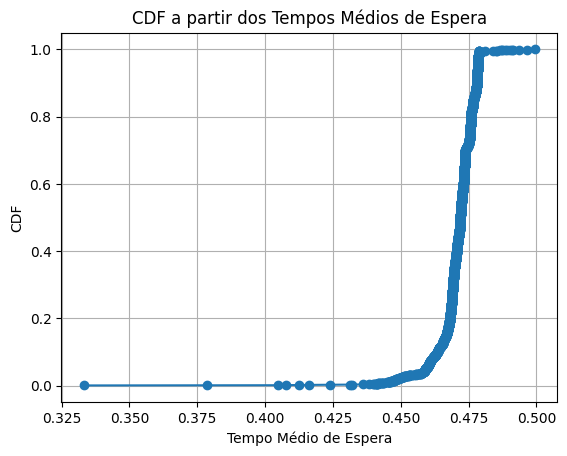

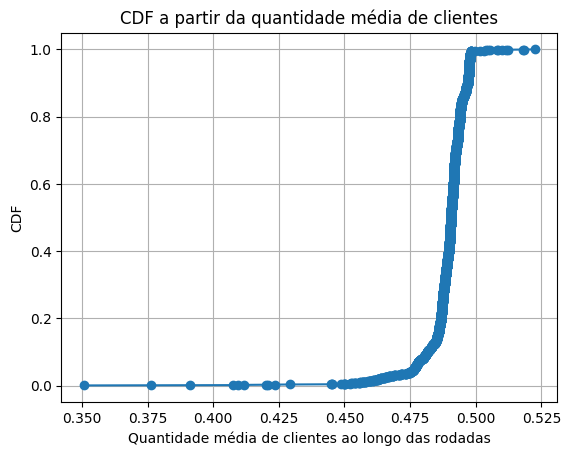

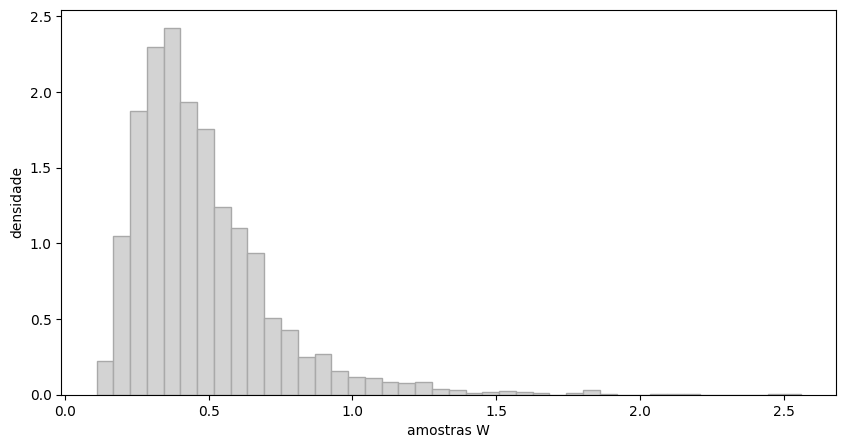

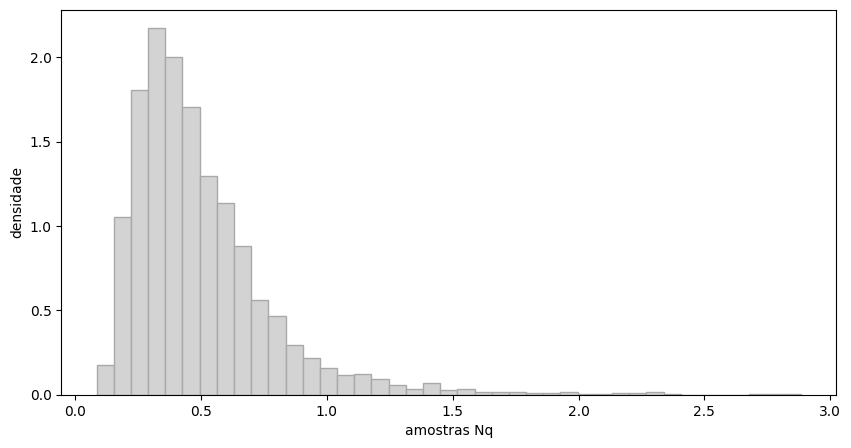

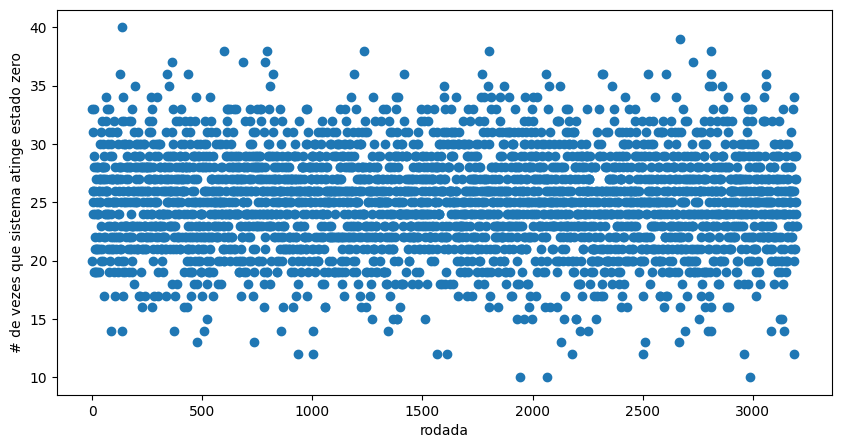

------------------
Média de W (tempo médio de espera ao longo das rodadas)
Intervalo de Confiança: 0.470 a 0.487
------------------
Variância de W - t-Student
Intervalo de Confiança: 0.624 a 0.669
------------------
Média de Nq (média do número de clientes ao longo das rodadas)
Intervalo de Confiança: 0.487 a 0.507
------------------
Variância de Nq - t-Student
Intervalo de Confiança: 1.108 a 1.191
------------------
Média de vezes que sistema atinge estado zero por rodada
Intervalo de Confiança: 24.845 a 25.135


In [ ]:
random.seed(0)
def exp10():
  return generate_exp(1.0)

def exp20():
  return generate_exp(2.0)

simulate(N_RODADAS, MIN_CLIENTES, exp10, exp20, print_values=True, graph_values=True)

## Caso 2 - Fila MM1

p = 0.5

lambda = 2

mi = 4

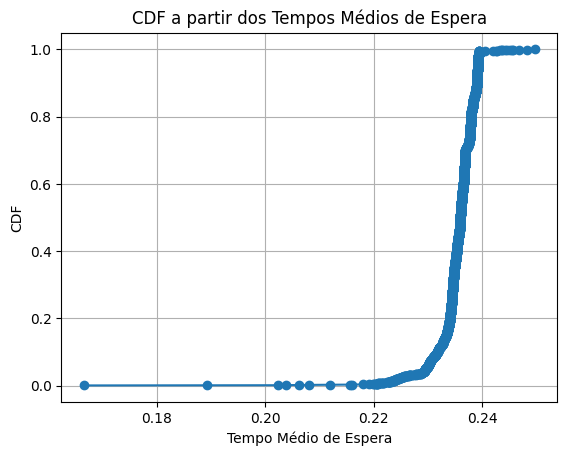

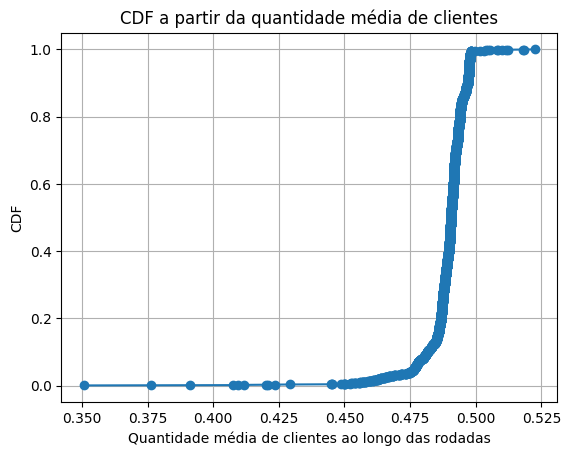

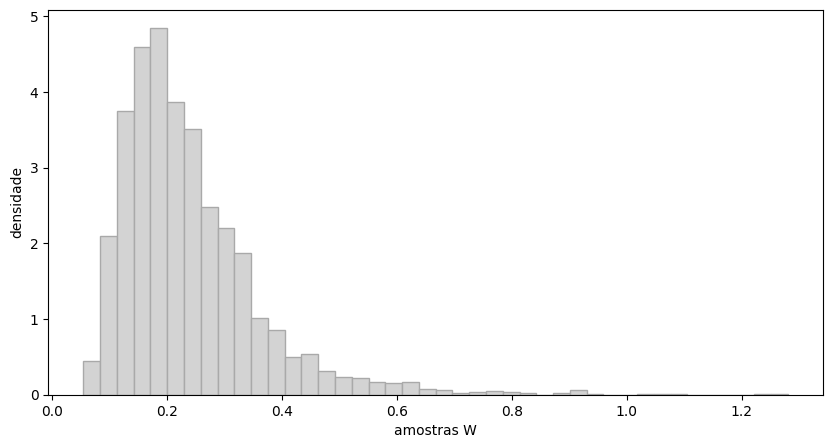

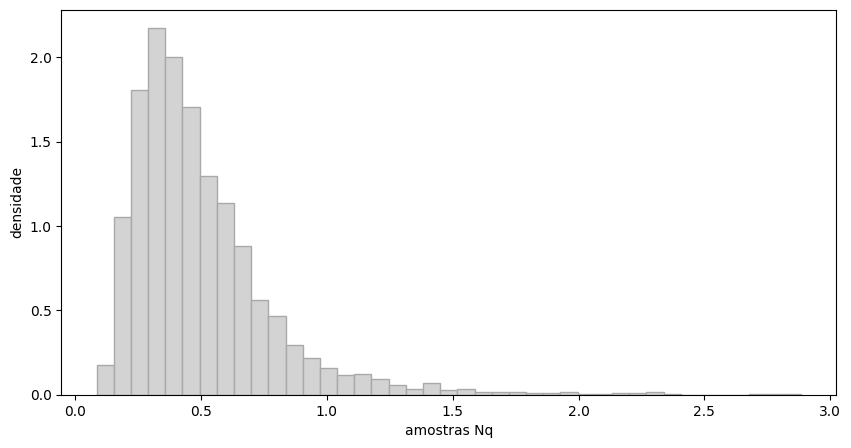

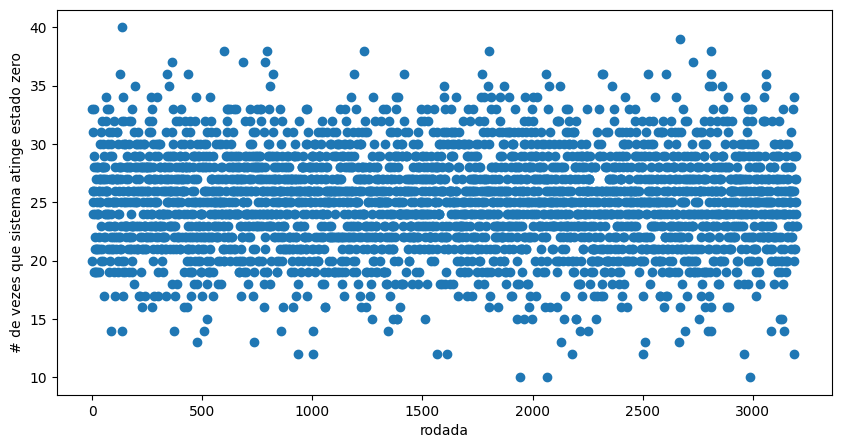

------------------
Média de W (tempo médio de espera ao longo das rodadas)
Intervalo de Confiança: 0.235 a 0.243
------------------
Variância de W - t-Student
Intervalo de Confiança: 0.156 a 0.167
------------------
Média de Nq (média do número de clientes ao longo das rodadas)
Intervalo de Confiança: 0.487 a 0.507
------------------
Variância de Nq - t-Student
Intervalo de Confiança: 1.108 a 1.191
------------------
Média de vezes que sistema atinge estado zero por rodada
Intervalo de Confiança: 24.845 a 25.135


In [ ]:
random.seed(0)
def exp40():
  return generate_exp(4.0)

def exp20():
  return generate_exp(2.0)

simulate(N_RODADAS, MIN_CLIENTES, exp20, exp40, print_values=True, graph_values=True)

## Caso 3 - Fila MM1

p = 1.05

lambda = 1.05

mi = 1

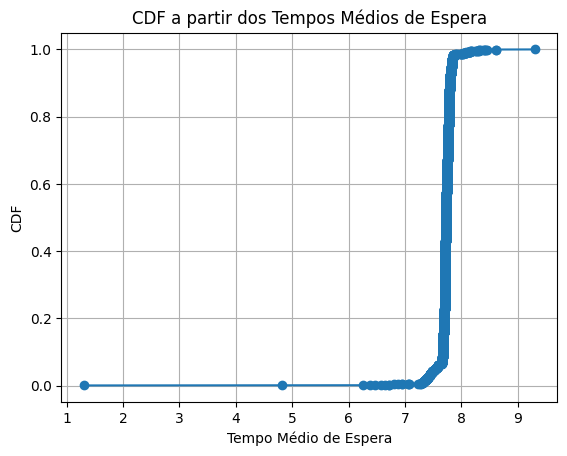

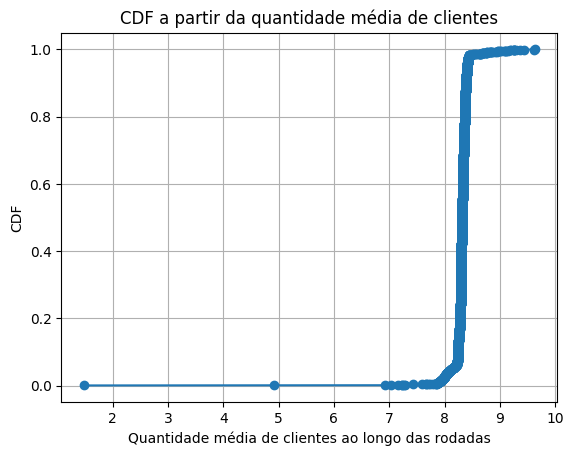

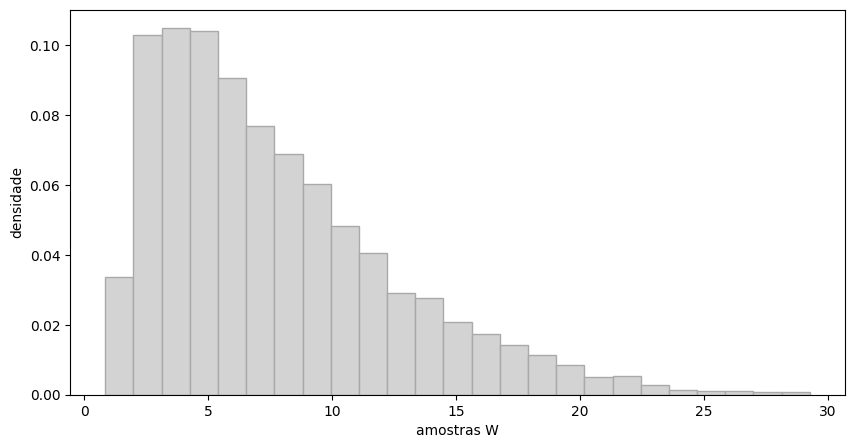

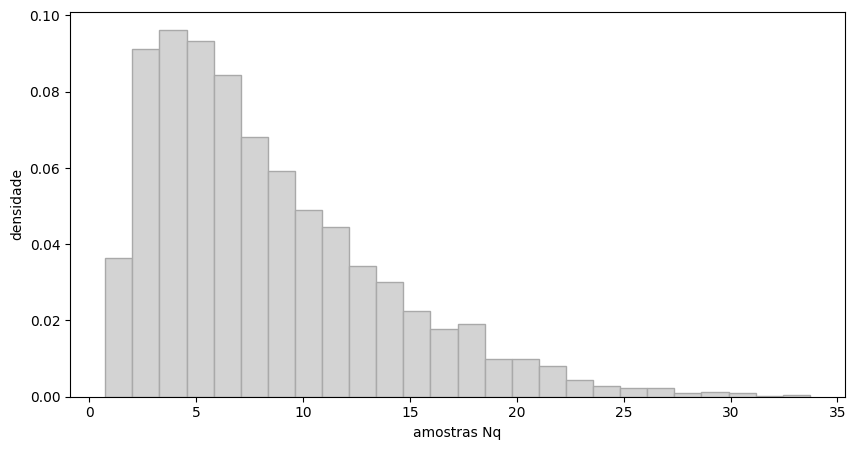

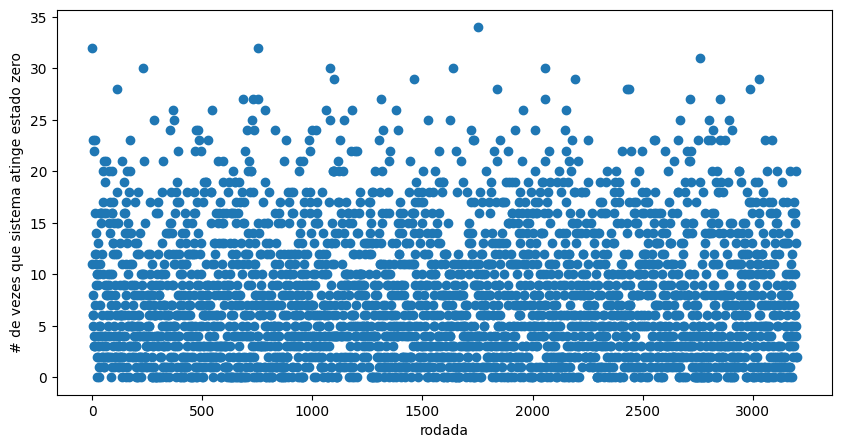

------------------
Média de W (tempo médio de espera ao longo das rodadas)
Intervalo de Confiança: 7.568 a 7.902
------------------
Variância de W - t-Student
Intervalo de Confiança: 30.040 a 32.392
------------------
Média de Nq (média do número de clientes ao longo das rodadas)
Intervalo de Confiança: 8.147 a 8.521
------------------
Variância de Nq - t-Student
Intervalo de Confiança: 36.966 a 39.955
------------------
Média de vezes que sistema atinge estado zero por rodada
Intervalo de Confiança: 7.574 a 8.007


In [ ]:
random.seed(0)
def exp10():
  return generate_exp(1.0)

def exp105():
  return generate_exp(1.05)

simulate(N_RODADAS, MIN_CLIENTES, exp105, exp10, print_values=True, graph_values=True)

## Caso 4 - Fila MM1

p = 1.10

lambda = 1.10

mi = 1

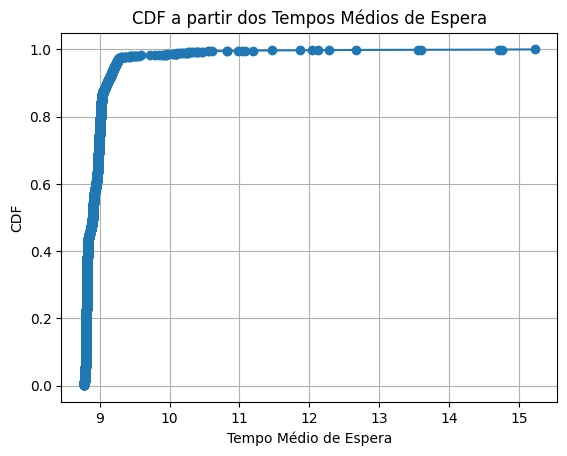

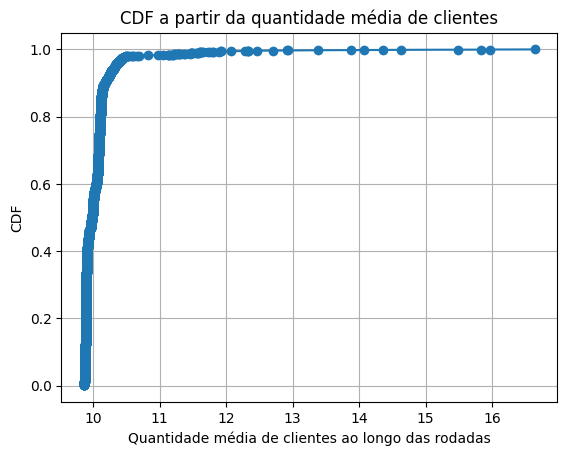

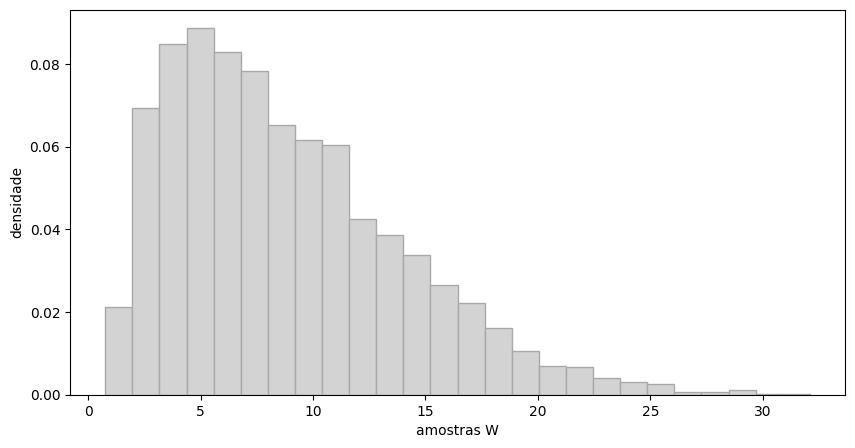

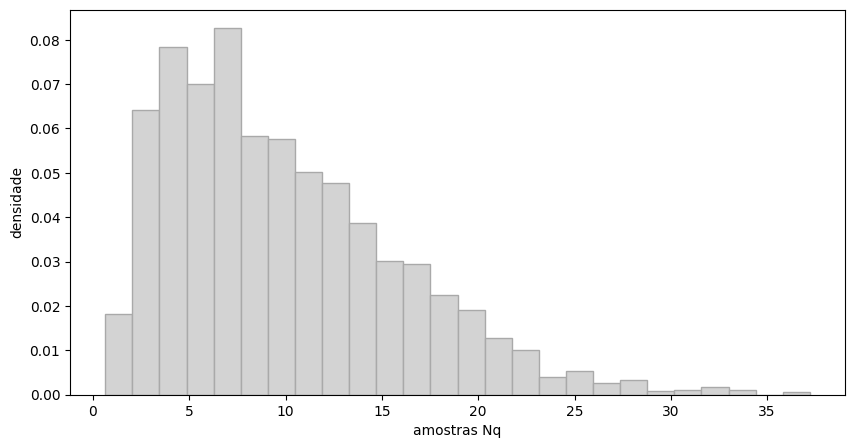

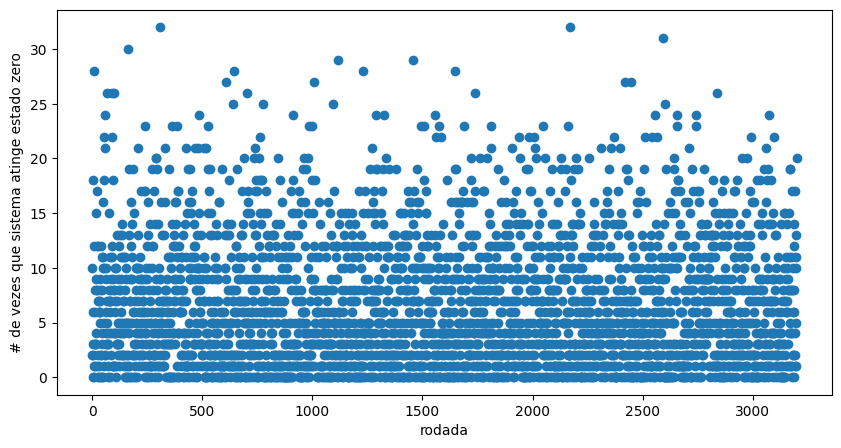

------------------
Média de W (tempo médio de espera ao longo das rodadas)
Intervalo de Confiança: 8.660 a 9.016
------------------
Variância de W - t-Student
Intervalo de Confiança: 36.309 a 39.039
------------------
Média de Nq (média do número de clientes ao longo das rodadas)
Intervalo de Confiança: 9.722 a 10.140
------------------
Variância de Nq - t-Student
Intervalo de Confiança: 48.492 a 52.354
------------------
Média de vezes que sistema atinge estado zero por rodada
Intervalo de Confiança: 6.298 a 6.695


In [ ]:
random.seed(0)
def exp10():
  return generate_exp(1.0)

def exp110():
  return generate_exp(1.10)

simulate(N_RODADAS, MIN_CLIENTES, exp110, exp10, print_values=True, graph_values=True)